# Transformer Training

In [1]:
# system
import os
import pickle
import gzip

# data manipulation
import pandas as pd
import numpy as np

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# get real dataset
with gzip.open('../../result/one_hot_encoding/gene_id_label_ohe.pkl.gz', 'rb') as f:
    data = pickle.load(f)

X = np.stack(data['upstream_region_encoded'].values)
Y = data['DE'].values

X_positive = X[Y==1]
Y_positive = Y[Y==1]
X_negative = X[Y==0]
Y_negative = Y[Y==0]
selected_indices = np.random.choice(X_negative.shape[0], size=X_positive.shape[0], replace=False)
X_negative = X_negative[selected_indices]
Y_negative = Y_negative[selected_indices]

X = np.concatenate((X_positive,X_negative),axis=0)
Y = np.concatenate((Y_positive,Y_negative),axis=0)
print(X.shape)
print(Y.shape)

X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=123)
print(X_train.shape)
print(X_dev.shape)
print(Y_train.shape)
print(Y_dev.shape)

(8252, 2000, 4)
(8252,)
(6601, 2000, 4)
(1651, 2000, 4)
(6601,)
(1651,)


In [3]:
# data preprocess
X_train = np.expand_dims(X_train, axis=-1)
X_dev = np.expand_dims(X_dev, axis=-1) 

### Hyperparameters:

In [4]:
BATCH_SIZE = 256
EPOCH_SIZE = 20
LEARNING_RATE = 1e-3

In [5]:
p_n_ratio = np.sum(Y_train)/(Y_train.shape[0]-np.sum(Y_train))

In [6]:
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(torch.FloatTensor(X_dev), torch.FloatTensor(Y_dev))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [8]:
class DNATransformer(nn.Module):
    def __init__(self, 
                 d_model=128,
                 nhead=8,
                 num_layers=3,
                 dim_feedforward=256,
                 dropout=0.1,
                 num_classes=2):
        super(DNATransformer, self).__init__()
        
        self.embedding = nn.Linear(4, d_model)
        self.pos_encoder = nn.Parameter(torch.randn(1, 2000, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)  # directly ouput logits
        )
        
    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoder
        x = self.transformer(x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)  # Returns logits
        return x

def train_and_evaluate(model, train_loader, val_loader, num_epochs=5, p_n_ratio=p_n_ratio):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    pos_weight = 1/p_n_ratio if p_n_ratio > 0 else 1
    class_weights = torch.tensor([1., pos_weight], device=device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()
            
            if inputs.shape[-1] == 1:
                inputs = inputs.squeeze(-1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        scheduler.step()
        
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).long()  # Convert to long
                
                if inputs.shape[-1] == 1:
                    inputs = inputs.squeeze(-1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predicted = outputs.argmax(dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Collect predictions and true labels
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
        conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
        tn, fp, fn, tp = conf_matrix.ravel()

        accuracy = (tp + tn) / (tp + fp + fn + tn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%, True Positives (TP): {tp}')
        print(f"F1-Score: {f1_score:.2f}")
        print('-' * 50)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return history

Using device: cuda
Epoch 1/20:
Train Loss: 0.7096, Train Acc: 50.57%
Val Loss: 0.6934, Val Acc: 50.94%, True Positives (TP): 0
F1-Score: 0.00
--------------------------------------------------
Epoch 2/20:
Train Loss: 0.6899, Train Acc: 53.26%
Val Loss: 0.6834, Val Acc: 56.45%, True Positives (TP): 258
F1-Score: 0.42
--------------------------------------------------
Epoch 3/20:
Train Loss: 0.6802, Train Acc: 57.14%
Val Loss: 0.6830, Val Acc: 56.57%, True Positives (TP): 328
F1-Score: 0.48
--------------------------------------------------
Epoch 4/20:
Train Loss: 0.6768, Train Acc: 57.14%
Val Loss: 0.6832, Val Acc: 55.00%, True Positives (TP): 165
F1-Score: 0.31
--------------------------------------------------
Epoch 5/20:
Train Loss: 0.6780, Train Acc: 57.22%
Val Loss: 0.6862, Val Acc: 55.72%, True Positives (TP): 201
F1-Score: 0.35
--------------------------------------------------
Epoch 6/20:
Train Loss: 0.6763, Train Acc: 57.85%
Val Loss: 0.6843, Val Acc: 56.94%, True Positives (TP

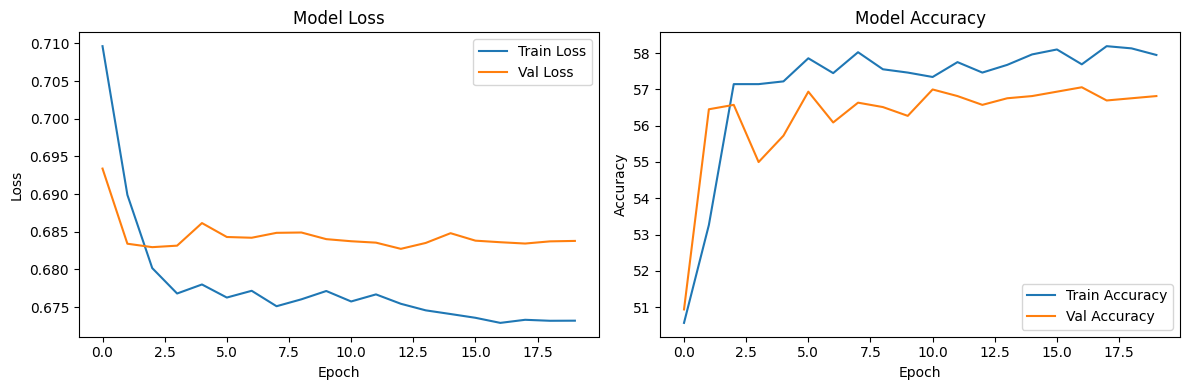

In [9]:
model = DNATransformer()
history = train_and_evaluate(model, train_loader, val_loader, num_epochs=EPOCH_SIZE, p_n_ratio=1.0)

In [10]:
# further analyasis

device = 'cuda'
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).long()

        inputs = inputs.squeeze(-1).squeeze(-1)
        outputs = model(inputs)
        predicted = outputs.argmax(dim=1)

        # Collect predictions and true labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
tn, fp, fn, tp = conf_matrix.ravel()

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")


True Positives (TP): 325
False Positives (FP): 228
True Negatives (TN): 613
False Negatives (FN): 485
Accuracy: 56.81%
Precision: 0.59
Recall: 0.40
F1-Score: 0.48
